# Social Media Data Analysis Project: 

## 0. Useful Fuctions and packages

In [ ]:
import nltk
from nltk.corpus import wordnet
import xml.etree.ElementTree as ET
import json
import re
import time
import requests
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

In [553]:
def read_json(file_path):
    with open(file_path, 'r') as file: 
        f=json.load(file)
    return f

## 1.Data collection and pre-processing

### 1.1 Word Net Affect

#### 1.1.0 Functions 

In [3]:
#Define fuction to get all child and subtrees of a given emotion
def get_subterms(emotion, list_emo):
    '''
    Definition:  This recursive fuction appends all the elements of a subtree of a given emotion to an emotion list. It also prints the name of the leaf nodes when the end is reached. 
    Parameters: - emotion(str): name of the root of subtree 
                 - list_emo(list): list in wich the elements will be stored.
    
    '''
    #get all child emotions 
    emotion_list=[child.attrib.get('name') for child in root_emotions if child.attrib.get('isa')==emotion]
    # if no child emotions left, emotion is a leaf node and should be printed (also stop case for recursion)
    if len(emotion_list)==0: 
        print(f'End of tree at: {emotion}')
    else:
        #otherwise for each child apend the list to the original list and call the fuction on it
        for child_emo in emotion_list:
            list_emo.append(child_emo)
            get_subterms(child_emo,list_emo)

In [7]:
#get all the nouns corresponding to the lists
def get_nounids(in_list):
    '''
    Definition:  This fuction estracts the noun ids from the sysets given an emotion name 
    Parameters: - in_list(list): List with all the emotion names that should get a noun id
    
    '''
    out_list=[]
    for noun in root_synsets[0]:
        if noun.attrib.get('categ') in in_list:
            out_list.append(noun.attrib.get('id'))
    return out_list
        

In [10]:
def get_other_pos_ids(n_ids):
    '''
    Definition:  This fuction estracts the ids from verb, adjectives and adverbs related to the noun id
    Parameters: - n_ids(list): List with all the noun ids
    
    '''
    out_list=[]
    #iterate over the other pos(adj, verb,adv)
    for pos in root_synsets[1:]:
        for elem in pos:
            if elem.attrib.get('noun-id') in n_ids: 
                e_id=elem.attrib.get('id')
                #save results as a dictionary with id and pos label
                out_list.append({'pos':f'{e_id[0]}', 'id':int(e_id[2:])})
    #apend the n_ids to the list
    for noun in n_ids:
        out_list.append({'pos':f'{noun[0]}', 'id':int(noun[2:])})
        
    return out_list

In [14]:
def get_synset_lemmas(emotion):
    '''
    Definition:  This fuction estracts the synset lemmas for a given emotion in string form (without id)
    Parameters: - emotion(str): Emotions for wich sysnset lemmas shoud be extracted
    
    '''
    syns=[]
    for synset in wordnet.synsets(f"{emotion}"):
        # for each synset of word append lemma names
        syns.append(synset.lemma_names())

    return list(set([i for syn in syns for i in syn]))

#### 1.1.1 Download data

In [2]:
#Define Tree of emotions WordNetAffect
tree_emotions = ET.parse('Data/wn-domains-3.2/wn-affect-1.1/a-hierarchy.xml')
#Get the root 
root_emotions =tree_emotions.getroot()

In [5]:
#Define tree for synsets 
tree_synsets=ET.parse('Data/wn-domains-3.2/wn-affect-1.1/a-synsets-30.xml')
#Get the root 
root_synsets=tree_synsets.getroot()

#### 1.1.2 Extract synsets

In [4]:
#initialize lists 
joy_list=[]
sadness_list=[]
#call fuction to get all element of the subtree
get_subterms('joy',joy_list)
get_subterms('sadness',sadness_list)

End of tree at: amusement
End of tree at: euphoria
End of tree at: triumph
End of tree at: bang
End of tree at: titillation
End of tree at: exuberance
End of tree at: happiness
End of tree at: bonheur
End of tree at: gladness
End of tree at: hilarity
End of tree at: jocundity
End of tree at: jollity
End of tree at: rejoicing
End of tree at: comfortableness
End of tree at: togetherness
End of tree at: buoyancy
End of tree at: carefreeness
End of tree at: satisfaction-pride
End of tree at: smugness
End of tree at: fulfillment
End of tree at: gloat
End of tree at: dolefulness
End of tree at: gloom
End of tree at: heavyheartedness
End of tree at: world-weariness
End of tree at: misery
End of tree at: forlornness
End of tree at: weepiness
End of tree at: dolor
End of tree at: woe
End of tree at: plaintiveness
End of tree at: self-pity
End of tree at: attrition
End of tree at: guilt
End of tree at: repentance
End of tree at: joylessness
End of tree at: demoralization
End of tree at: helpless

In [8]:
# get the noun ids for all elements 
n_ids_joy=get_nounids(joy_list)
n_ids_sadness=get_nounids(sadness_list)

# get adj, verb, adv id based in the noun ids
ids_joy=get_other_pos_ids(n_ids_joy)
ids_sadness=get_other_pos_ids(n_ids_sadness)

#get synset lemmas using the pos tag and word id extracted above
syms_joy=[wordnet.synset_from_pos_and_offset(sym['pos'],sym['id']).lemma_names() for sym in ids_joy]
syms_sadness=[wordnet.synset_from_pos_and_offset(sym['pos'],sym['id']).lemma_names() for sym in ids_sadness]

In [13]:
#retrieve words that are in affect hirarchie but not in sysets file 
synset_terms_joy=[elem.attrib.get('categ') for elem in root_synsets[0]]
not_in_synset_joy=[elem for elem in joy_list if elem not in synset_terms_joy]
print(f'Joy Words for which no noun-id colud be found in the synysets file: {not_in_synset_joy}\n')
synset_terms_sadness=[elem.attrib.get('categ') for elem in root_synsets[0]]
not_in_synset_sadness=[elem for elem in sadness_list if elem not in synset_terms_sadness]
print(f'Sadness Words for which no noun-id colud be found in the synysets file: {not_in_synset_sadness}')

# get synsets for the terms that are not in the sysnsets file 
add_joy=[get_synset_lemmas(joy_word) for joy_word in not_in_synset_joy]
add_joy=[joy_word for word_list in add_joy for joy_word in word_list]

add_sadness=[get_synset_lemmas(sadness_word) for sadness_word in not_in_synset_sadness]
add_sadness=[sadness_word for word_list in add_sadness for sadness_word in word_list]

Joy Words for which no noun-id colud be found in the synysets file: ['amusement', 'merriment']

Sadness Words for which no noun-id colud be found in the synysets file: ['sorrow']


In [17]:
# join the two list of synonyms
syms_joy.append(add_joy)
syms_sadness.append(add_sadness)
#get rid of repeated words 
syms_joy=list(set([word for syn in syms_joy for word in syn]))
syms_sadness=list(set([word for syn in syms_sadness for word in syn]))

#### 1.1.3. Stemm words in list

In [19]:
from nltk.stem import *

In [20]:
stemmer = PorterStemmer()
stem_syms_joy=list(set([stemmer.stem(sym) for sym in syms_joy]))
stem_syms_sadness=list(set([stemmer.stem(sym) for sym in syms_sadness]))

#### 1.1.4. Print overview and save results 

In [21]:
print (f'N Joy: { len(stem_syms_joy)}\nN sadness: {len(stem_syms_sadness)}')

N Joy: 135
N sadness: 155


In [24]:
dict_wna={'joy': stem_syms_joy, 'sadness': stem_syms_sadness}

In [27]:
with open('WNA_words.json', 'w') as file: 
    json.dump(dict_wna,file)

### 1.2 LIWC

#### 1.2.0. Functions 

In [536]:
# Small adaption from the package: https://github.com/evanll/liwc-text-analysis-python/blob/master/liwc/liwc.py
def load_dict_file(filepath):
    liwc_file = open(filepath)

    # Key, category dict
    categories = {}

    # Word, cat_name dict
    lexicon = {}

    # '%' signals a change in the .dic file.
    # (0-1) Cats, ids
    # (>1) Words, cat_ids
    percent_sign_count = 0

    for line in liwc_file:
        stp = line.strip()

        if stp:
            #parts = stp.split('\t')
            parts= re.split(r'\s|\/', stp)

            if parts[0] == '%':
                percent_sign_count += 1
            else:
                # If the percent sign counter equals 1, parse the LIWC
                # categories
                if percent_sign_count == 1:
                    categories[parts[0]] = parts[1]
                # Else, parse lexicon
                else:
                    cats=[]
                    for cat_id in parts[1:]:
                        cats.append(cat_id.strip())
                    lexicon[parts[0]]=cats

    return categories, lexicon

#### 1.2.1. Extract words from English LIWC

In [537]:
# load LIWC
categories, lexicon=load_dict_file('Data/LIWC/LIWC2007_English.dic')

# get ids associated with posemo and sad
val_posemo=list(filter(lambda x: categories[x] == 'posemo', categories))[0]
val_sad=list(filter(lambda x: categories[x] == 'sad', categories))[0]

#append words that contain id to a list
posemo_words=[]
sad_words=[]
for key in list(lexicon.keys()): 
    if val_posemo in lexicon[key]: 
        posemo_words.append(key)
    if val_sad in lexicon[key]: 
        sad_words.append(key)

In [636]:
#print overview
print (f'N posemo: { len(posemo_words)}\nN sadness: {len((sad_words))}')

N posemo: 406
N sadness: 101


In [541]:
#save list of words 
dict_save_english={'posemo': posemo_words, 'sad': sad_words}
with open('LIWC_words_english.json', 'w') as file: 
    json.dump(dict_save_english,file)
    

#### 1.2.2. Extract words from German LIWC

In [637]:
#suffix g represent german 

# load LIWC
categories_g, lexicon_g=load_dict_file('Data/LIWC/LIWC2007_German.dic')

# get ids associated with posemo and sad
val_posemo_g=list(filter(lambda x: categories_g[x] == 'Posemo', categories_g))[0]
val_sad_g=list(filter(lambda x: categories_g[x] == 'Sad', categories_g))[0]

#append words that contain id to a list
posemo_words_g=[]
sad_words_g=[]
for key in list(lexicon_g.keys()): 
    if val_posemo_g in lexicon_g[key]: 
        posemo_words_g.append(key)
    if val_sad_g in lexicon_g[key]: 
        sad_words_g.append(key)

In [638]:
#print overview
print (f'N posemo: { len(posemo_words_g)}\nN sadness: {len((sad_words_g))}')

N posemo: 636
N sadness: 184


In [901]:
#save list of words 
dict_save_german={'posemo': posemo_words_g, 'sad': sad_words_g}
with open('LIWC_words_german.json', 'w') as file: 
    json.dump(dict_save_german,file)

### 1.3 Google N-gram corpus 

#### 1.3.0. Functions

This fuction was taken from the following article: https://www.geeksforgeeks.org/scrape-google-ngram-viewer-using-python/

In [46]:
def runQuery(query, start_year=1900,
			end_year=2019, corpus='en-2019',
			smoothing=0):

	# converting a regular string to
	# the standard URL format
	# eg: "geeks for,geeks" will
	# convert to "geeks%20for%2Cgeeks"
	query = urllib.parse.quote(query)

	# creating the URL
	url = 'https://books.google.com/ngrams/json?content=' + query +'&year_start=' + str(start_year) + '&year_end=' +str(end_year) + '&corpus=' + str(corpus) + '&smoothing=' +str(smoothing) + ''

	# requesting data from the above url
	response = requests.get(url)

	# extracting the json data from the response we got
	output = response.json()

	# creating a list to store the ngram data
	return_data = []

	if len(output) == 0:
		# if no data returned from site,
		# print the following statement
		return "No data available for this Ngram."
	else:
		# if data returned from site,
		# store the data in return_data list
		for num in range(len(output)):
			
			# getting the name
			return_data.append((output[num]['ngram'],
								
								# getting ngram data
								output[num]['timeseries'])
							)

	return return_data


In [161]:
def get_ngrams(list_of_words, start_year=1900,
			end_year=2019, corpus='en-2019',
			smoothing=0):
    '''
    Definition:  This fuction extracts the the Google 1gram timeseries for all words in the given list   
    Parameters: - list_of_words(list): Words for wich the 1grame timeseries shoud be extracted 
                - query parameters: start_year, end_year, corpus, smoothing --> to run the query
    
    '''
    timeseries=[]
    #iterate over all words 
    for word in list_of_words:
        #query 1gram
        ts=runQuery(word,start_year=start_year, end_year=end_year, corpus=corpus,smoothing=smoothing)
        #if something is returned 
        if type(ts)==list:
            #save the result
            ts_dict={}
            ts_dict['word']=ts[0][0]
            i=0
            for year in range(1900,2020):
                ts_dict[f'{year}']=ts[0][1][i]
                i=i+1
            #append the result to the resultslist
            timeseries.append(ts_dict)
            # for not getting kicked out wait
            time.sleep(1.5)
    return timeseries
    

### 1.3.1 Word Net Affect

In [42]:
#extract lists from json
wna=read_json('WNA_words.json')
wna_joy=wna['joy']
wna_sadness=wna['sadness']

In [162]:
# get 1 grams for all the words in each list 
joy_all=get_ngrams(wna_joy)
sadness_all=get_ngrams(wna_sadness)
norm_the=get_ngrams(['the'])

KeyboardInterrupt: 

In [54]:
#save the timeseries 
with open('wna_joy_ts.json', 'w') as file: 
    json.dump(joy_all,file)
with open('wna_sadness_ts.json', 'w') as file: 
    json.dump(sadness_all,file)

### 1.3.2 LIWC

#### 1.3.2.1. English

In [562]:
#extract lists from json
liwc_words=read_json('LIWC_words_english.json')
licw_posemo=[word.replace('*','') for word in liwc_words['posemo']]
licw_sad=[word.replace('*','') for word in liwc_words['sad']]

In [564]:
# get 1 grams for all the words in each list
liwc_posemo_1grams=get_ngrams(licw_posemo)
liwc_sad_1grams=get_ngrams(licw_sad)
norm_the=get_ngrams(['the'])

#### 1.3.2.1. German

In [599]:
liwc_words_ger=read_json('LIWC_words_german.json')
licw_posemo_ger=[word.replace('*','') for word in liwc_words_ger['posemo']]
licw_sad_ger=[word.replace('*','') for word in liwc_words_ger['sad']]

In [693]:
# get 1 grams for all the words in each list for germany 
liwc_posemo_1grams_ger=get_ngrams(licw_posemo_ger,corpus='de-2019')
liwc_sad_1grams_ger=get_ngrams(licw_sad_ger,corpus='de-2019')
norm_the_ger=get_ngrams(['der','die','das'],corpus='de-2019')

In [694]:
#sum frequencies of der,die,das for germany 
sumnorm_the_ger=[]
dict_norm={}
#iterate over all years
for year in range(1900,2020):
    #for each year initialize sum
    val_year=0
    for word_i in range(3):
        #sum frequencies from the 3 words
        val_year=val_year+norm_the_ger[word_i][f'{year}']
    #appnd sum to the year
    dict_norm[f'{year}']=val_year
sumnorm_the_ger.append(dict_norm)      

### 1.4 Literary Misery Index

#### 1.4.0. Functions

In [465]:
def normalized_year_freq(freq_list, norm_word_list):
    '''
    Definition:  This fuction normalizes the frequency of each word in the freq_list by the norm_word and standarices the average of each year by the mean and standar deviation of the whole series.  
    Parameters: - freqlist(list of dictionaries): list with ts of frequencies for each word of the list  
                - freqlist(list of dictionaries): should only contain one dictionary with the year frequencies of the normalizing word(s)
    
    '''
    # normalize by the frequency of the word in norm_word_list
    w_ts=[]
    for year in range(1900,2020):
        sum_norm_freq=0
        for word in freq_list:
            #normalize the frequency by the norm_word
            norm_freq=word[f'{year}']/(norm_word_list[0][f'{year}'])
            #add the normalize frequencies 
            sum_norm_freq=sum_norm_freq+norm_freq
            #divide va the number of words and append 
        w_ts.append(sum_norm_freq/len(freq_list))
    #calculate mean and std of timeseries 
    mean=np.mean(w_ts)
    std=np.std(w_ts)
    # z normalize timeseries 
    z_ts=[]
    for freq in w_ts:
        z_t=(freq-mean)/std
        z_ts.append(z_t)
    return z_ts
    

### 1.4.1 WNA

In [466]:
# normalize and stadarize frequency lists 
wna_norm_ts_joy=normalized_year_freq(joy_all, norm_the)
wna_norm_ts_sad=normalized_year_freq(sadness_all, norm_the)

#calculate the literary misery index for each year
LM_wna=[sadness - joy for joy,sadness in zip(wna_norm_ts_joy,wna_norm_ts_sad)]

### 1.4.2 LIWC

#### 1.4.2.1. English

In [566]:
# normalize and stadarize frequency lists 
liwc_posemo_ts=normalized_year_freq(liwc_posemo_1grams, norm_the)
liwc_sad_ts=normalized_year_freq(liwc_sad_1grams, norm_the)

#calculate the literary misery index for each year
LM_liwc=[sadness - joy for joy,sadness in zip(liwc_posemo_ts,liwc_sad_ts)]

#### 1.4.2.1. German

In [695]:
# normalize and stadarize frequency lists 
liwc_posemo_ger_ts=normalized_year_freq(liwc_posemo_1grams_ger, sumnorm_the_ger)
liwc_sad_ger_ts=normalized_year_freq(liwc_sad_1grams_ger, sumnorm_the_ger)

#calculate the literary misery index for each year
LM_liwc_ger=[sadness - joy for joy,sadness in zip(liwc_posemo_ger_ts,liwc_sad_ger_ts)]

### 1.4.3 Save results

In [906]:
LM_results={'wna':LM_wna, 'liwc_en': LM_liwc, 'liwc_de': LM_liwc_ger}
with open('LM.json', 'w') as file: 
    json.dump(LM_results,file)

### 1.5 Inflation

In [171]:
pip install world_bank_data --upgrade
import world_bank_data as wb

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for cachetools from https://files.pythonhosted.org/packages/a9/c9/c8a7710f2cedcb1db9224fdd4d8307c9e48cbddc46c18b515fefc0f1abbe/cachetools-5.3.1-py3-none-any.whl.metadata
  Created wheel for world_bank_data: filename=world_bank_data-0.1.3-py3-none-any.whl size=11120 sha256=1e50cac971a7b871d43b5c015fd1251603945ea7adef94622e5e0e2243e105e0
  Stored in directory: c:\users\anasa\appdata\local\pip\cache\wheels\a5\1c\b8\87ebf925901b98e6fe94fac09d156dadb5f3f50228926809db
Successfully built world_bank_data
Note: you may need to restart the kernel to use updated packages.


In [217]:
inflation_ts=wb.get_series('FP.CPI.TOTL.ZG', id_or_value='id', date='1960:2019',simplify_index=True)
#unemployment_ts=wb.get_series('SL.UEM.TOTL.NE.ZS', id_or_value='id', date='1960:2019',simplify_index=True)

In [902]:
inflation={}
for country in ['USA','DEU']:
    #extract inflation 
    inflation[country]=inflation_ts.loc[country]

### 1.6 Unemployment 

#### 1.6.0 Function 

In [305]:
def read_fred_table(file_path,rate_name): 
    unemployment=pd.read_csv(file_path) 
    #extract the year from another date format
    unemployment['year']=[date[:4] for date in unemployment['DATE']]
    #new column with one name, and float format for rates
    unemployment['unemployment']=[float(rate) for rate in unemployment[rate_name]]
    unemployment.drop(['DATE',rate_name], inplace=True, axis=1)
    #years as index 
    unemployment.set_index('year',inplace=True)
    
    return unemployment

#### 1.6.1 Extract unemployment

In [306]:
UN_US=read_fred_table('Data/Unemployment/UNRATE.csv','UNRATE')
UN_GER=read_fred_table('Data/Unemployment/LMUNRRTTDEM156S.csv','LMUNRRTTDEM156S')

### 1.7 Economic Misery Index 

#### 1.7.0 Function 

In [701]:
def calculate_EM_ts(inflation, unemployment, country):
    '''
    Definition: This function calculates the economic misery index from the unemployment and inflation rate series for a goven country 
    Parameters: - inflation(pd series): Series of inflation rate 
                - unemployment(pd series): Series of unemployment rate
                - country(str): Country name for saving results to a df 
    
    '''
    #merge so only the years are kept where tdata for both indicators is available
    df_country=pd.merge(inflation,unemployment,how='inner',left_index=True,right_index=True)
    #calculate the economic misery 
    df_country['EM']=df_country['FP.CPI.TOTL.ZG']+df_country['unemployment']
    #keep df for later use
    EM_df[country]=df_country
    return df_country['EM']

#### 1.7.1 Calculate Economic misery 

In [702]:
EM_df={}
EM_US=calculate_EM_ts(inflation['USA'], UN_US, 'USA')
EM_GER=calculate_EM_ts(inflation['DEU'], UN_US, 'DEU')

In [909]:
EM_results={'US':list(EM_US), 'GER':list(EM_GER)}
with open('EM.json', 'w') as file: 
    json.dump(EM_results,file)

## 2. Analysis

Observation: Since the economic indicators are only available since 1960, I will filter the misery index to only contain those years. I collected all the N-grams since 1900 too se if they looked simililar to the paper my project is inspired on. 

### 2.0 Functions 

#### 2.0.1 For analysis 

In [792]:
def get_MA_series(series, lag): 
    '''
    Definition: This function get the moving average of a series for a given window 
    Parameters: - series(pd series): Series for which MA should be calculated 
                - lag (int): Window size for the moving average 
    '''
    #define windows
    window=series.rolling(lag)
    #get mean 
    MA_series=window.mean()
    return MA_series[lag-1:]

In [475]:
def get_lag_correlations(LM_arr, EM_series):
    '''
    Definition: This function returns a dictionary with the moving average and lagged values series for a given series as well as their correlation with the given Lm array
    Parameters: - EM_series(pd series): Series for which MA, lag and correlations should be calculated 
                - LM_arr(np.array): array of the LM
    '''
    #initialize list for saving results of all lags
    corr_res=[]
    for lag in range(1,25):
        res_lag={'lag':lag}
        #get moving average series 
        res_lag['series_ma']=get_MA_series(series=EM_series, lag=lag)
        # get correlation moving average and LM index 
        corr_ma=stats.pearsonr(LM_arr[lag-1:],res_lag['series_ma'])
        res_lag['corr_ma']=corr_ma.statistic
        # get lagged series 
        res_lag['series_l']=EM_series.shift(lag)[lag:]
        # get correlation lagged value and LM index
        corr_l=stats.pearsonr(LM_arr[lag:],res_lag['series_l'])
        res_lag['corr_l']=corr_l.statistic

        corr_res.append(res_lag)
    return corr_res

In [865]:
def get_bootstraped_corrs(LM_list,EM_series, sample_size=40):
    '''
    Definition: This function returns a list with the correlations of the bootstrap samples 
    Parameters: - EM_series(pd series): Series used in correlation 
                - LM_list(list): LM list used in correlation 
                - sample_size(int): size of bootstrap sample 
    '''
    #set seed for result reproduction 
    random.seed(12345)
    #define both series (also their index) 
    start=EM_series.index.start
    stop=EM_series.index.stop
    index_range=range(start,stop)
    LM_s=pd.Series(LM_list, index=index_range, name='LM')
    EM_series.index=index_range
    #turn series into a dataframe
    all_df=pd.concat([EM_series, LM_s], axis=1)
    #intialize list for saving the correlations
    correlations=[]
    # iterate as many samples 
    for i in range(10000):
        sample=all_df.sample(n=sample_size, replace=True)
        #Define correlation variable
        LM_sample=np.array(sample['LM'])
        EM_sample=sample['EM']
        #get correlation 
        p_corr=stats.pearsonr(LM_sample,EM_sample)
        correlations.append(p_corr.statistic)
    #print 95% cofidence intervall 
    print(f'KI for corr: [{np.percentile(correlations,2.5)}, {np.percentile(correlations,97.5)}]')
    return correlations

#### 2.0.2 For plotting

In [667]:
def TimeSeries2Plot(series_r,label_r,series_b,label_b,title='',xlab='Year',ylab='Misery Score'):
    '''
    Definition: This function returns a plot with 2 timeseries  
    Parameters: - series_r(pd series): Series to be plotted in red
                - label_r(str): Label of red series 
                - series_b(pd series): Series to be plotted in black
                - label_b(str): Label of black series
                - rest is selfexplanatory ( can be found in matplotlib.pyplot
    '''
    #define figure
    plt.figure(figsize=(16, 8), dpi=150)

    #plot Lines 
    plt.plot(series_r, color='red', marker='o',  ms=3, label= label_r)
    plt.plot(series_b, color='black', marker='o',  ms=3, label= label_b)

    #Titel and axis Labels 
    plt.xlabel(xlab, fontsize=15, weight='bold')
    plt.ylabel(ylab,fontsize=15, weight='bold')
    plt.ylim((0,25))
    plt.xlim((series_b.index.start,series_b.index.stop))
    plt.locator_params(axis='x', nbins=6)
    plt.title(title, fontsize=16,weight='bold')
    plt.legend(fontsize=15)
    plt.show()

In [669]:
def Corr2Plot(lagvar, series_r,label_r,series_b,label_b,xlab='Window(years)',ylab='Pearsons r', title=''):
    '''
    Definition: This function returns a plot with 2 lines 
    Parameters: - lagvar(list): List with the lags(windows) used 
                - series_r(pd series/list): correlations to be plotted in red
                - label_r(str): Label of red series 
                - series_r(pd series/list): correlations to be plotted in blue
                - label_b(str): Label of blue series
                - rest is selfexplanatory ( can be found in matplotlib.pyplot
    '''
    #define figure
    plt.figure(figsize=(8, 10), dpi=150)

    #plot Lines 
    plt.plot(lagvar, series_r, color='red', marker='o',  ms=4, label= label_r)
    plt.plot(lagvar, series_b, color='blue', marker='o',  ms=4, label= label_b)

    #Titel and axis Labels 
    plt.xlabel(xlab, fontsize=15, weight='bold')
    plt.ylabel(ylab,fontsize=15, weight='bold')
    plt.title(title,fontsize=16, weight='bold')

    plt.legend(fontsize=15)
    #plt.show()

In [818]:
def plot_bootstrap(bootstraped_corrs, realized_value, title=''):
    '''
    Definition: This function returns a histogram with the real value marked ad a red vline and the 95% intervall marked with 2 blue vlines.  
    Parameters: - bootstraped_corrs(list)= list of correlations from bootrapped samples 
                - realized_value: realized correlation from the whole sample
                - title(str): title of the plot 
    '''
    #define percentiles for plotting
    p25=np.percentile(bootstraped_corrs,2.5)
    p975=np.percentile(bootstraped_corrs,97.5)
    #plot histogram
    plt.figure(figsize=(8,6))
    hist=plt.hist(bootstraped_corrs, bins=50, alpha=0.5, color='black')
    plt.xlabel('Correlation',fontsize=15, weight='bold')
    plt.ylabel('Frequency',fontsize=15, weight='bold')
    # mark 95% cofidence intervall 
    plt.axvline(x=p25, color='blue')
    plt.axvline(x=p975, color='blue')
    # mark realized value 
    plt.axvline(x=realized_value, color='red')
    plt.title(title, fontsize=16, weight='bold')
    

### 2.1 Analysis between Literary Misery Index (WNA) and Economic Misery index (US)

#### 2.1.1. Plot timereseries

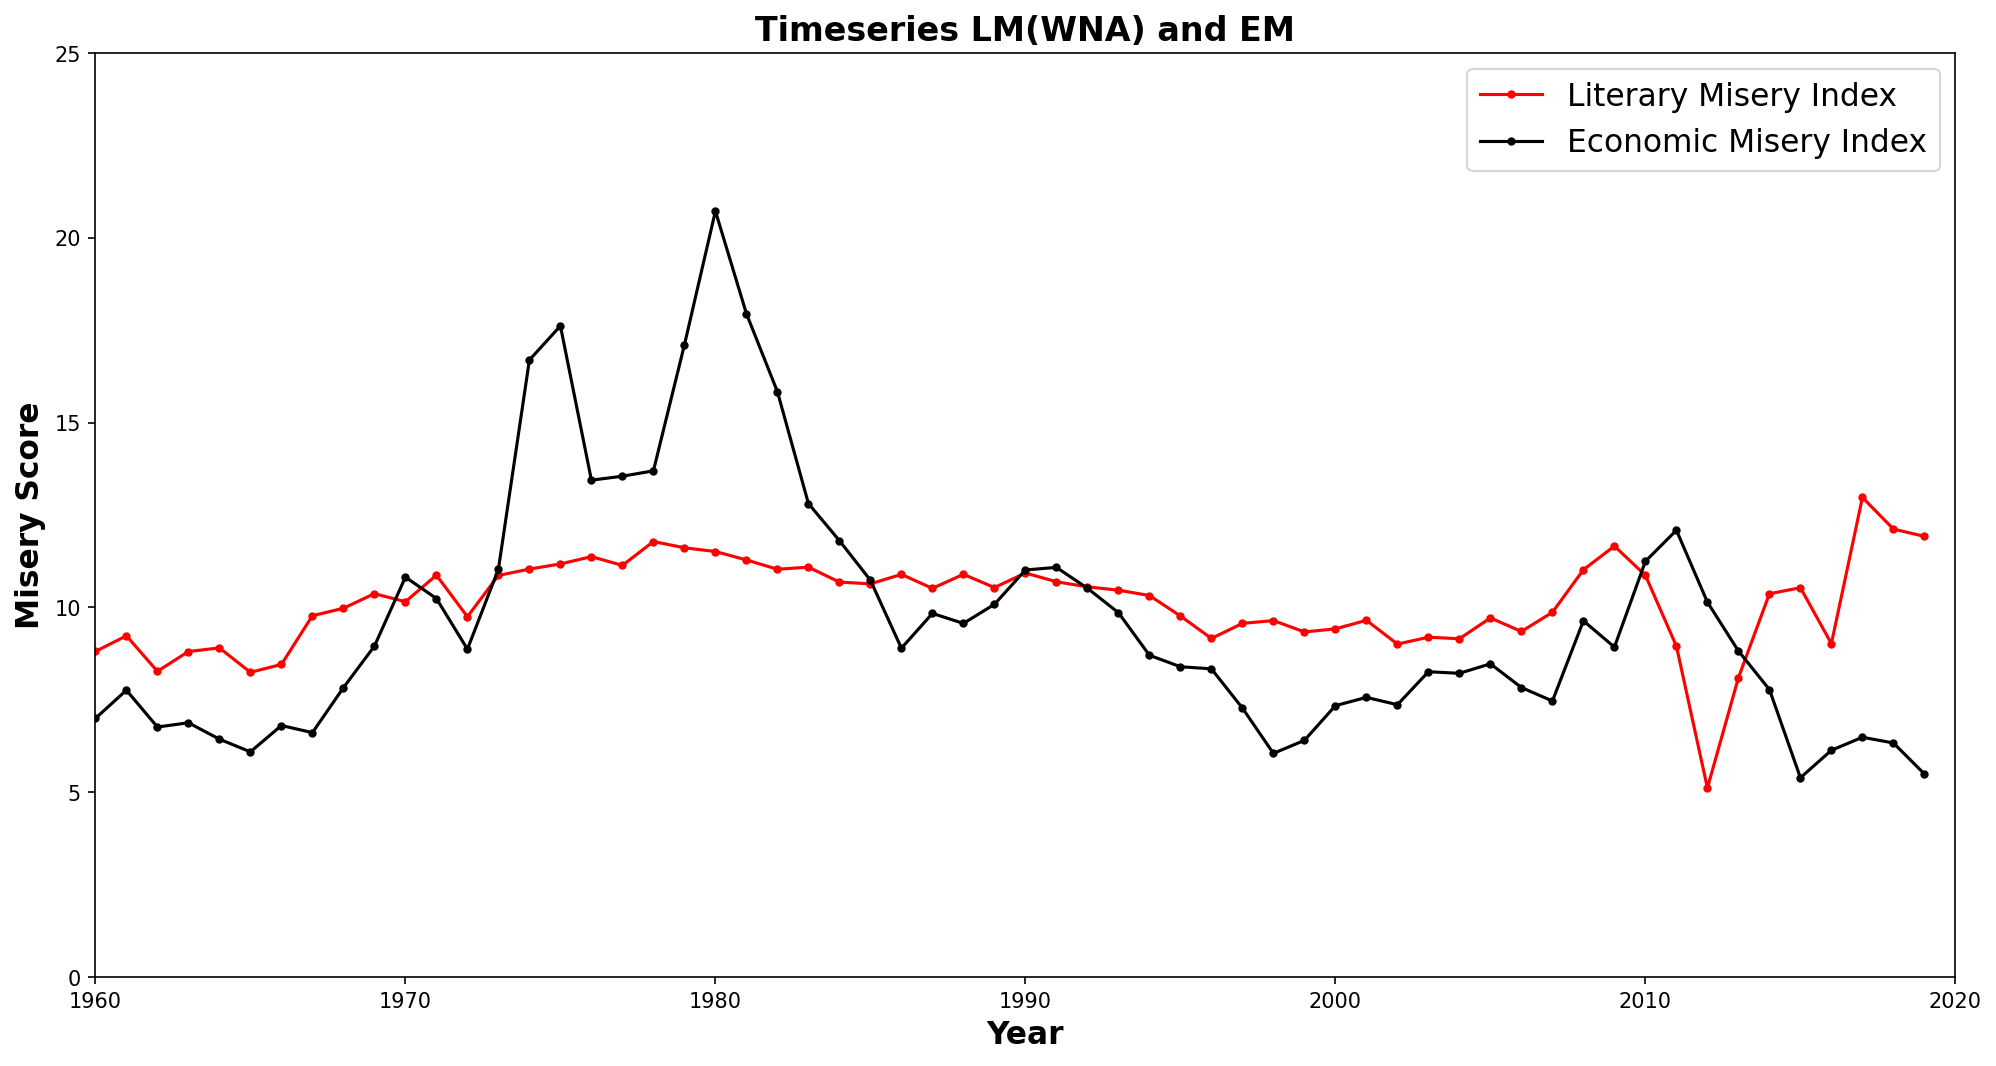

In [793]:
#Filter out the first 60 years so the LM goes from 1960 to 2019  
LM_wna_f=LM_wna[60:]
#scale LM to factor 10 for the plots and append to em series 
LM_wna_trans=pd.Series([LM *10 + 10 for LM in LM_wna_f],index=range(1960,2020))
#set index economic misery to range
EM_US.index=range(1960,2020)

#create plot 
TimeSeries2Plot(series_r=LM_wna_trans,label_r='Literary Misery Index',series_b=EM_US,label_b='Economic Misery Index',title='Timeseries LM(WNA) and EM',xlab='Year',ylab='Misery Score') 

#### 2.1.2. Correlations

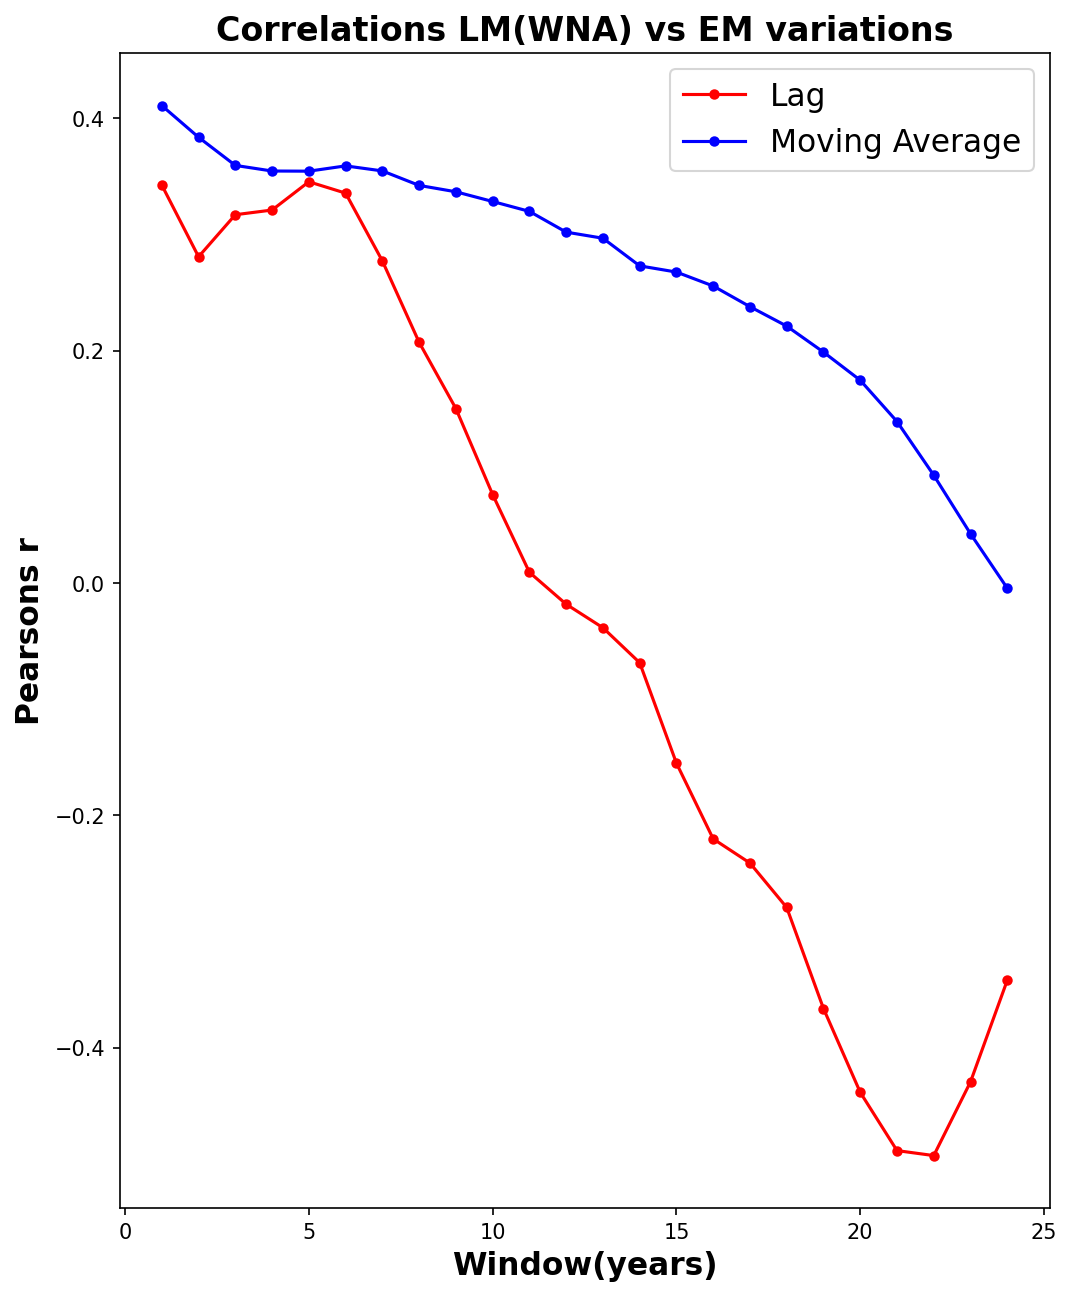

In [895]:
#turn Lm to an array
LM_array=np.array(LM_wna_f)

#get all series of lags and moving averages with their respective correlations 
corr_res=get_lag_correlations(LM_arr=LM_array, EM_series=EM_US)
# define sigle lists 
lags=[elem['lag'] for elem in corr_res]
corr_lag=[elem['corr_l'] for elem in corr_res]
corr_ma=[elem['corr_ma'] for elem in corr_res]
#plot correlations 
Corr2Plot(lagvar=lags,series_r=corr_lag,label_r='Lag',series_b=corr_ma,label_b='Moving Average',xlab='Window(years)',ylab='Pearsons r', title='Correlations LM(WNA) vs EM variations')

In [896]:
# Identify maximum of moving average and its index
print(f'Max corr index moving average: {corr_ma.index(max(corr_ma))}')
print(f'Max corr index moving average: {max(corr_ma)}')

Max corr index moving average: 0
Max corr index moving average: 0.4110750568782219


In [897]:
# get bootstraped correlations and 95% confidence intervalls 
c_wna_ma=get_bootstraped_corrs(LM_list=LM_wna_f,EM_series=EM_US, sample_size=40)

KI for corr: [0.1422508840568276, 0.738316492394778]


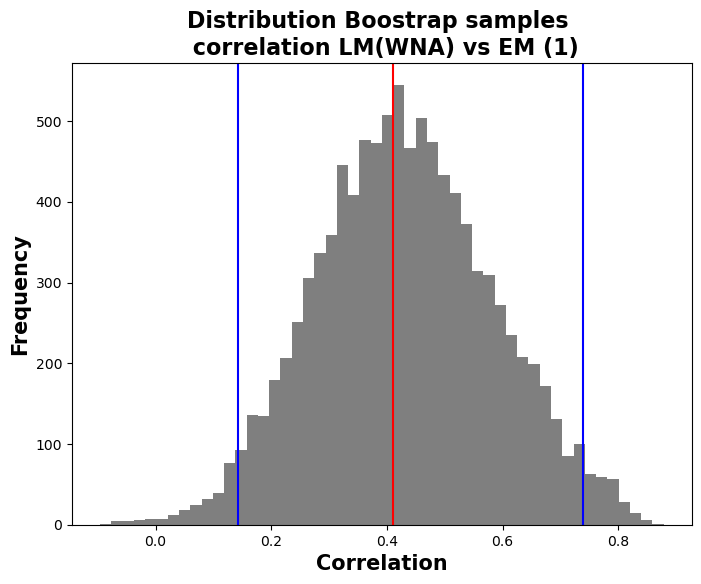

In [898]:
# plot histogram 
plot_bootstrap(bootstraped_corrs=c_wna_ma, realized_value=corr_res[0]['corr_ma'], title='Distribution Boostrap samples \n correlation LM(WNA) vs EM (1)')

In [829]:
# Identify maximum of moving lags and its index
print(f'Max corr index lag: {corr_lag.index(max(corr_lag))}')
print(f'Max corr moving lag: {max(corr_lag)}')

Max corr index lag: 4
Max corr moving lag: 0.3454992890646856


In [867]:
#define get EM series based on index and form 
EM_l_5=corr_res[4]['series_l']
# get rid if the first observations that where cu because of the lag (index + 1) 
LM_wna_l5=LM_wna_f[5:]
#get KI
c_wna_lag=get_bootstraped_corrs(LM_list=LM_wna_l5,EM_series=EM_l_5, sample_size=40)

KI for corr: [0.17267438121060646, 0.5273197820983215]


#### 2.1.3. Repeat analysis with sample 1960-2010

In [854]:
# filter out newer values 
lm_short=LM_array[:51]
em_short=EM_US[:51]
#get correlations
short_corr=get_lag_correlations(LM_arr=lm_short, EM_series=em_short)

In [868]:
# Identify maximum value 
#define list for correlation with shorter period of time 
short_corr_ma=[elem['corr_ma'] for elem in short_corr]
#Corr2Plot(lagvar=lags,series_r=short_corr_ma,label_r='1960-2010',series_b=corr_ma,label_b='1960-2019',xlab='Window(years)',ylab='Pearsons r')
print(f'Max corr index moving average: {short_corr_ma.index(max(short_corr_ma))}')
print(f'Max corr index moving average: {max(short_corr_ma)}')

Max corr index moving average: 0
Max corr index moving average: 0.7759242202598571


In [870]:
# get bootstraped correlations and 95% confidence intervalls 
c_wna_ma_short=get_bootstraped_corrs(LM_list=lm_short,EM_series=em_short, sample_size=40)

KI for corr: [0.6860507802173585, 0.8599769874846427]


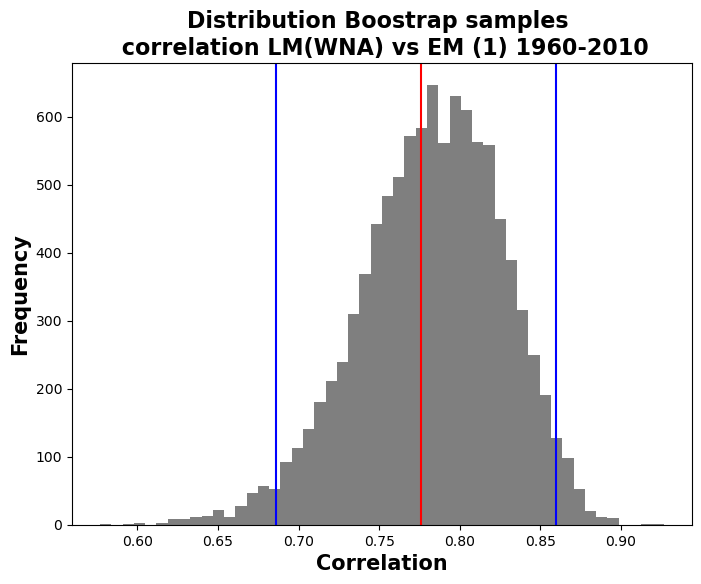

In [873]:
# plot histogram 
plot_bootstrap(bootstraped_corrs=c_wna_ma_short, realized_value=short_corr[0]['corr_ma'], title='Distribution Boostrap samples \n correlation LM(WNA) vs EM (1) 1960-2010')

### 2.2 Analysis between Literary Misery Index (LIWC) and Economic Misery index (US)

#### 2.2.1. Plot timereseries

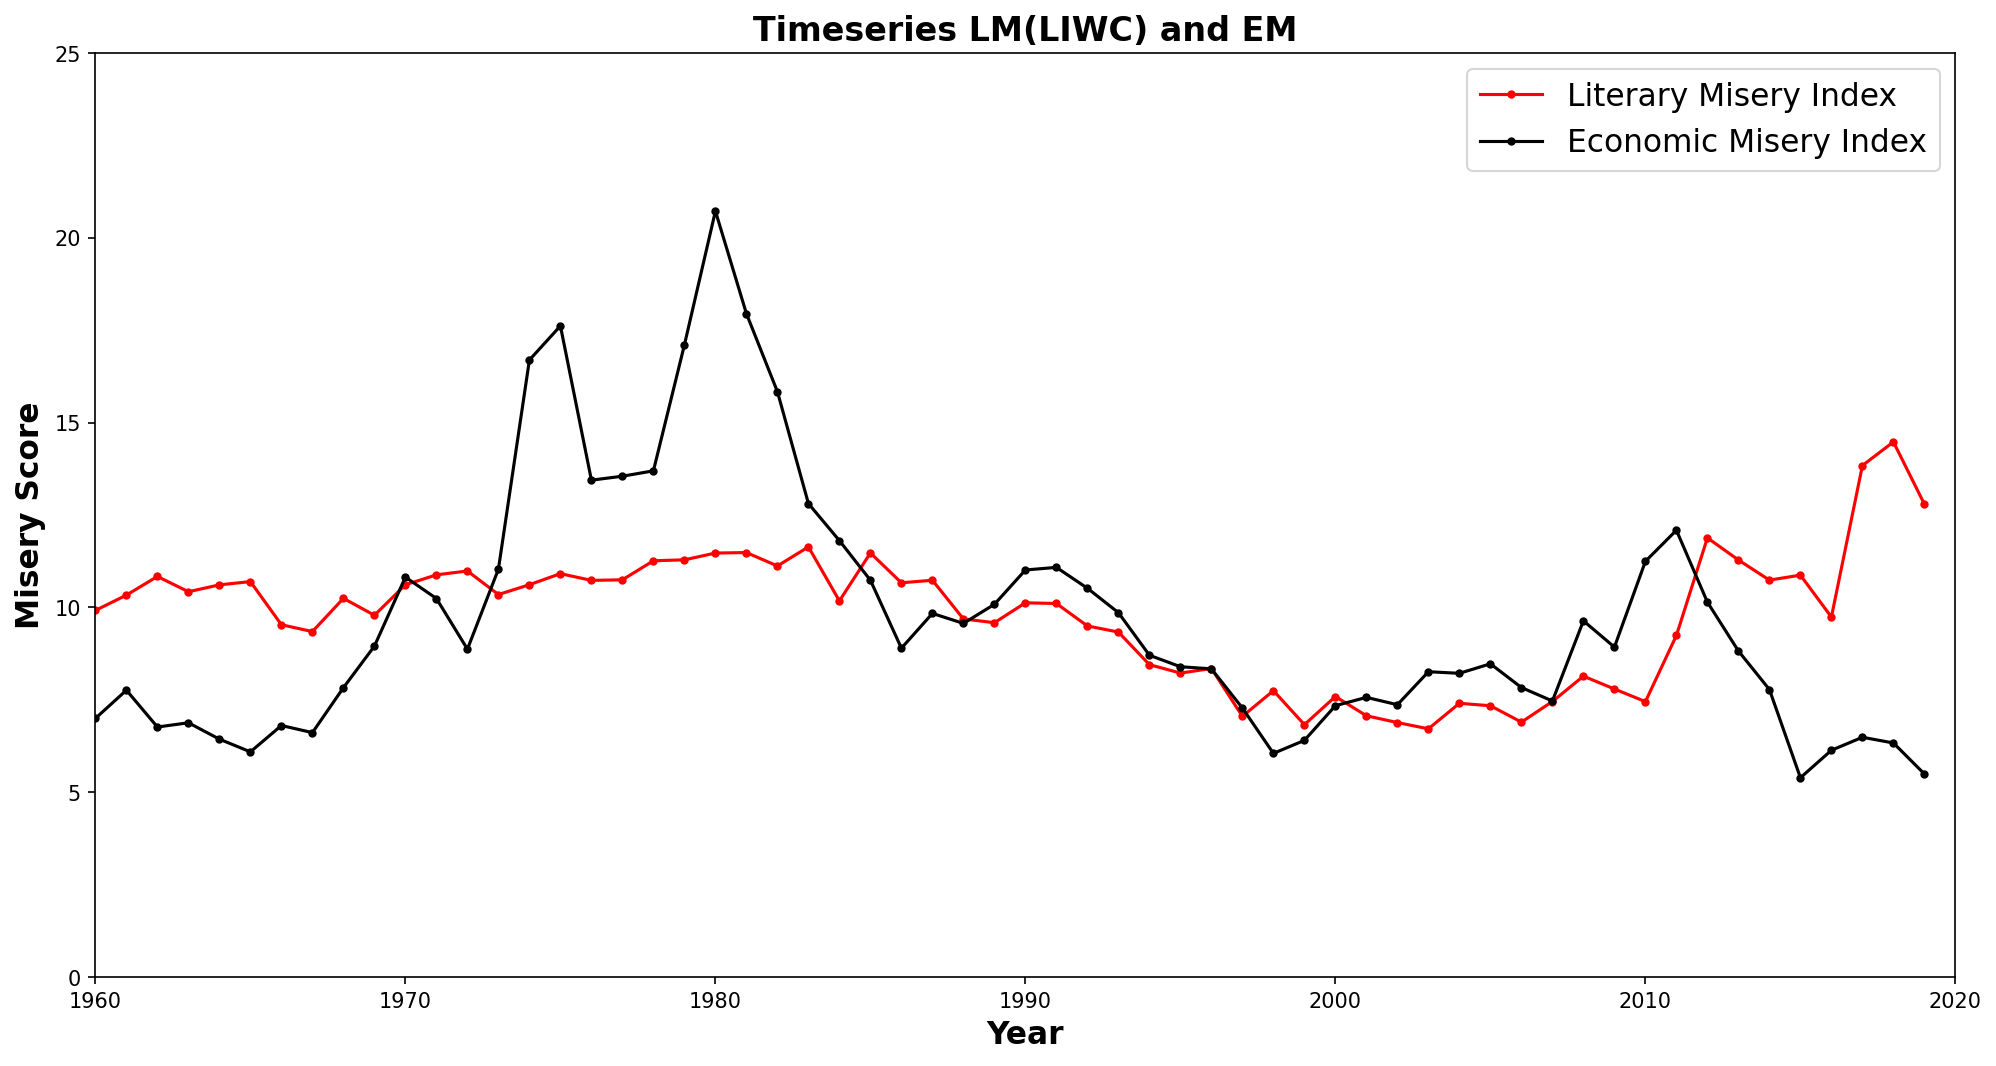

In [674]:
LM_liwc_f=LM_liwc[60:]
#scale LM to factor 10 for the plots and append to em series 
LM_liwc_trans=pd.Series([LM *10 +10 for LM in LM_liwc_f],index=range(1960,2020))
TimeSeries2Plot(series_r=LM_liwc_trans,label_r='Literary Misery Index',series_b=EM_US,label_b='Economic Misery Index',xlab='Year',ylab='Misery Score', title='Timeseries LM(LIWC) and EM')

#### 2.2.2. Correlations

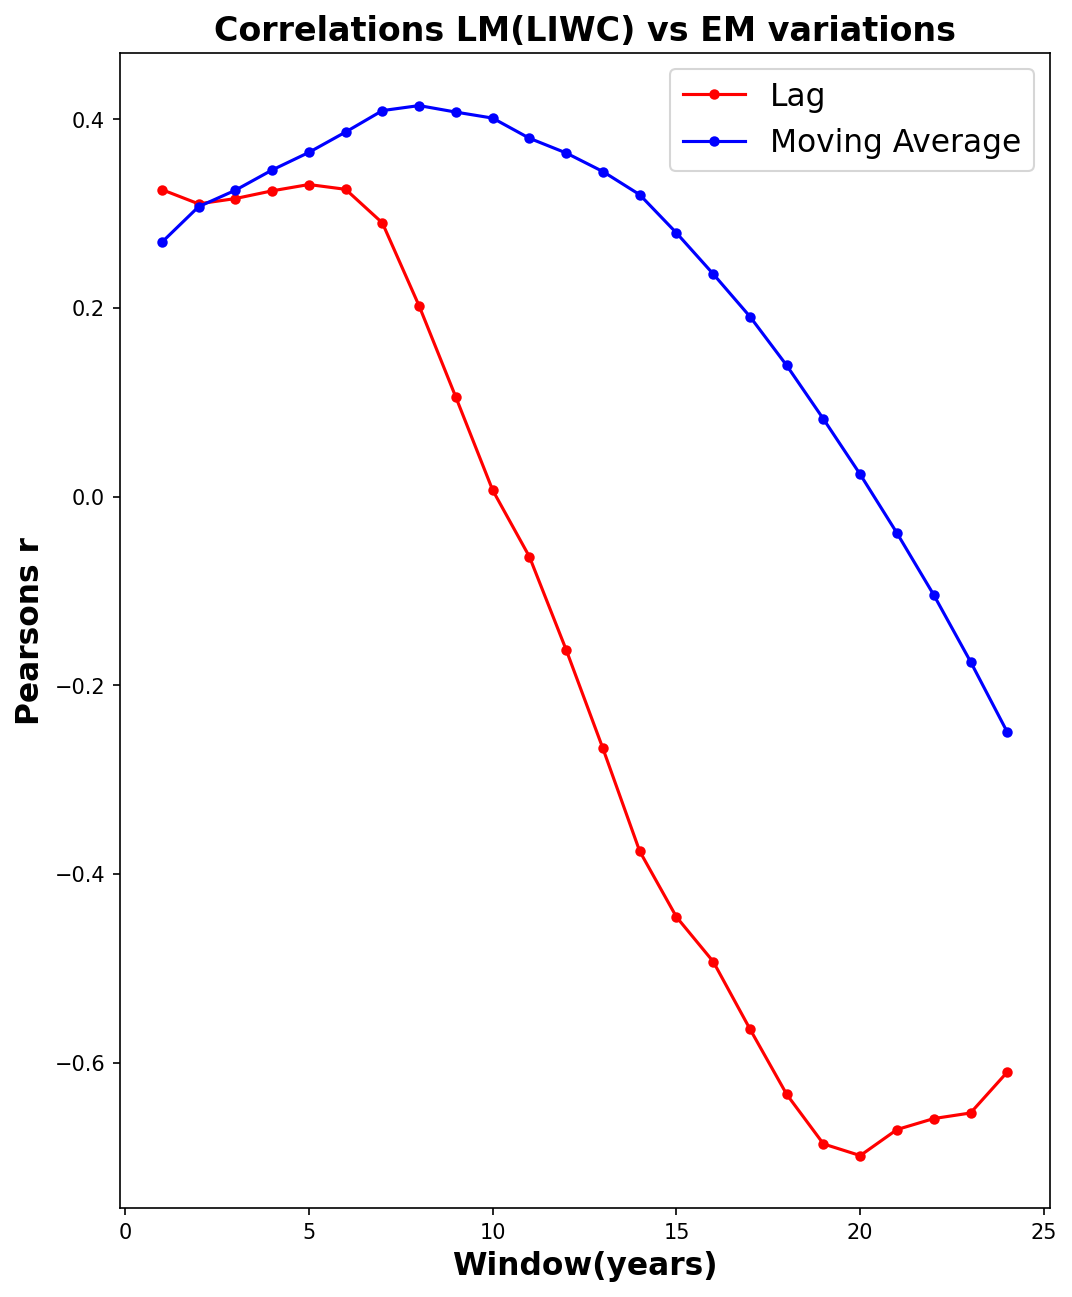

In [716]:
#turn Lm to an array
LM_liwc_array=np.array(LM_liwc_f)

#get all series of lags and moving averages with their respective correlations
corr_liwc_res=get_lag_correlations(LM_arr=LM_liwc_array, EM_series=EM_US)

# define single lists 
lags_liwc=[elem['lag'] for elem in corr_liwc_res]
corr_liwc_lag=[elem['corr_l'] for elem in corr_liwc_res]
corr_liwc_ma=[elem['corr_ma'] for elem in corr_liwc_res]

#plot correlations 
Corr2Plot(lagvar=lags_liwc,series_r=corr_liwc_lag,label_r='Lag',series_b=corr_liwc_ma,label_b='Moving Average',xlab='Window(years)',ylab='Pearsons r',title='Correlations LM(LIWC) vs EM variations')

In [874]:
# Identify maximum of moving average and its index
print(f'Max corr index moving average: {corr_liwc_ma.index(max(corr_liwc_ma))}')
print(f'Max corr index moving average: {max(corr_liwc_ma)}')

Max corr index moving average: 7
Max corr index moving average: 0.4143445309899146


In [880]:
#define get EM series based on index and form 
EM_ma_8=corr_liwc_res[7]['series_ma']
# get rid if the first observations that where cu because of the ma (same index) 
LM_ma_8=LM_liwc_f[7:]
#get KI
c_liwc_ma8=get_bootstraped_corrs(LM_list=LM_ma_8,EM_series=EM_ma_8, sample_size=40)

KI for corr: [0.16287188280429798, 0.6887188230867172]


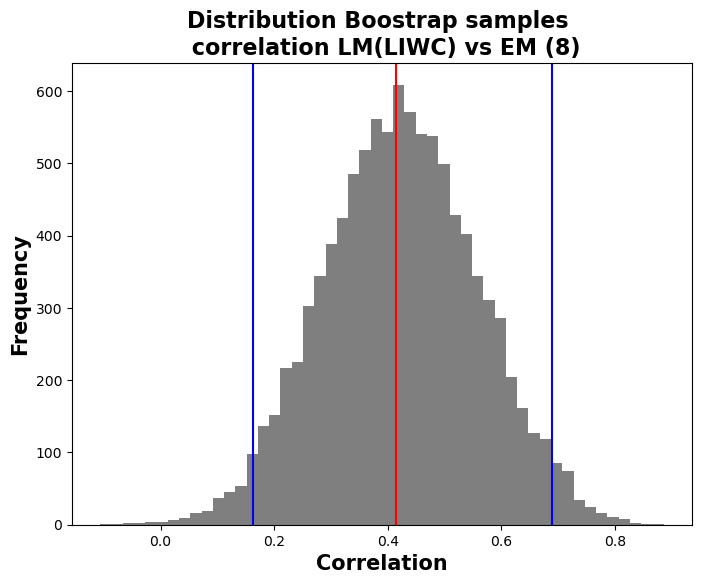

In [881]:
#plot histogram
plot_bootstrap(bootstraped_corrs=c_liwc_ma8, realized_value=corr_liwc_res[7]['corr_ma'], title='Distribution Boostrap samples \n correlation LM(LIWC) vs EM (8)')

In [905]:
print(f'Max corr index lag: {corr_liwc_lag.index(max(corr_liwc_lag))}')
print(f'Max corr moving lag: {max(corr_liwc_lag)}')

Max corr index lag: 4
Max corr moving lag: 0.33066836424557233


In [883]:
#define get EM series based on index and form 
EM_l_5_liwc=corr_liwc_res[4]['series_l']
# get rid if the first observations that where cu because of the lag (index + 1) 
LM_liwc_l5=LM_liwc_f[5:]
#get KI
c_liwc_lag=get_bootstraped_corrs(LM_list=LM_liwc_l5,EM_series=EM_l_5_liwc, sample_size=40)

KI for corr: [0.12332108677539554, 0.5435278379602234]


##### Plot timeseries for moving average 

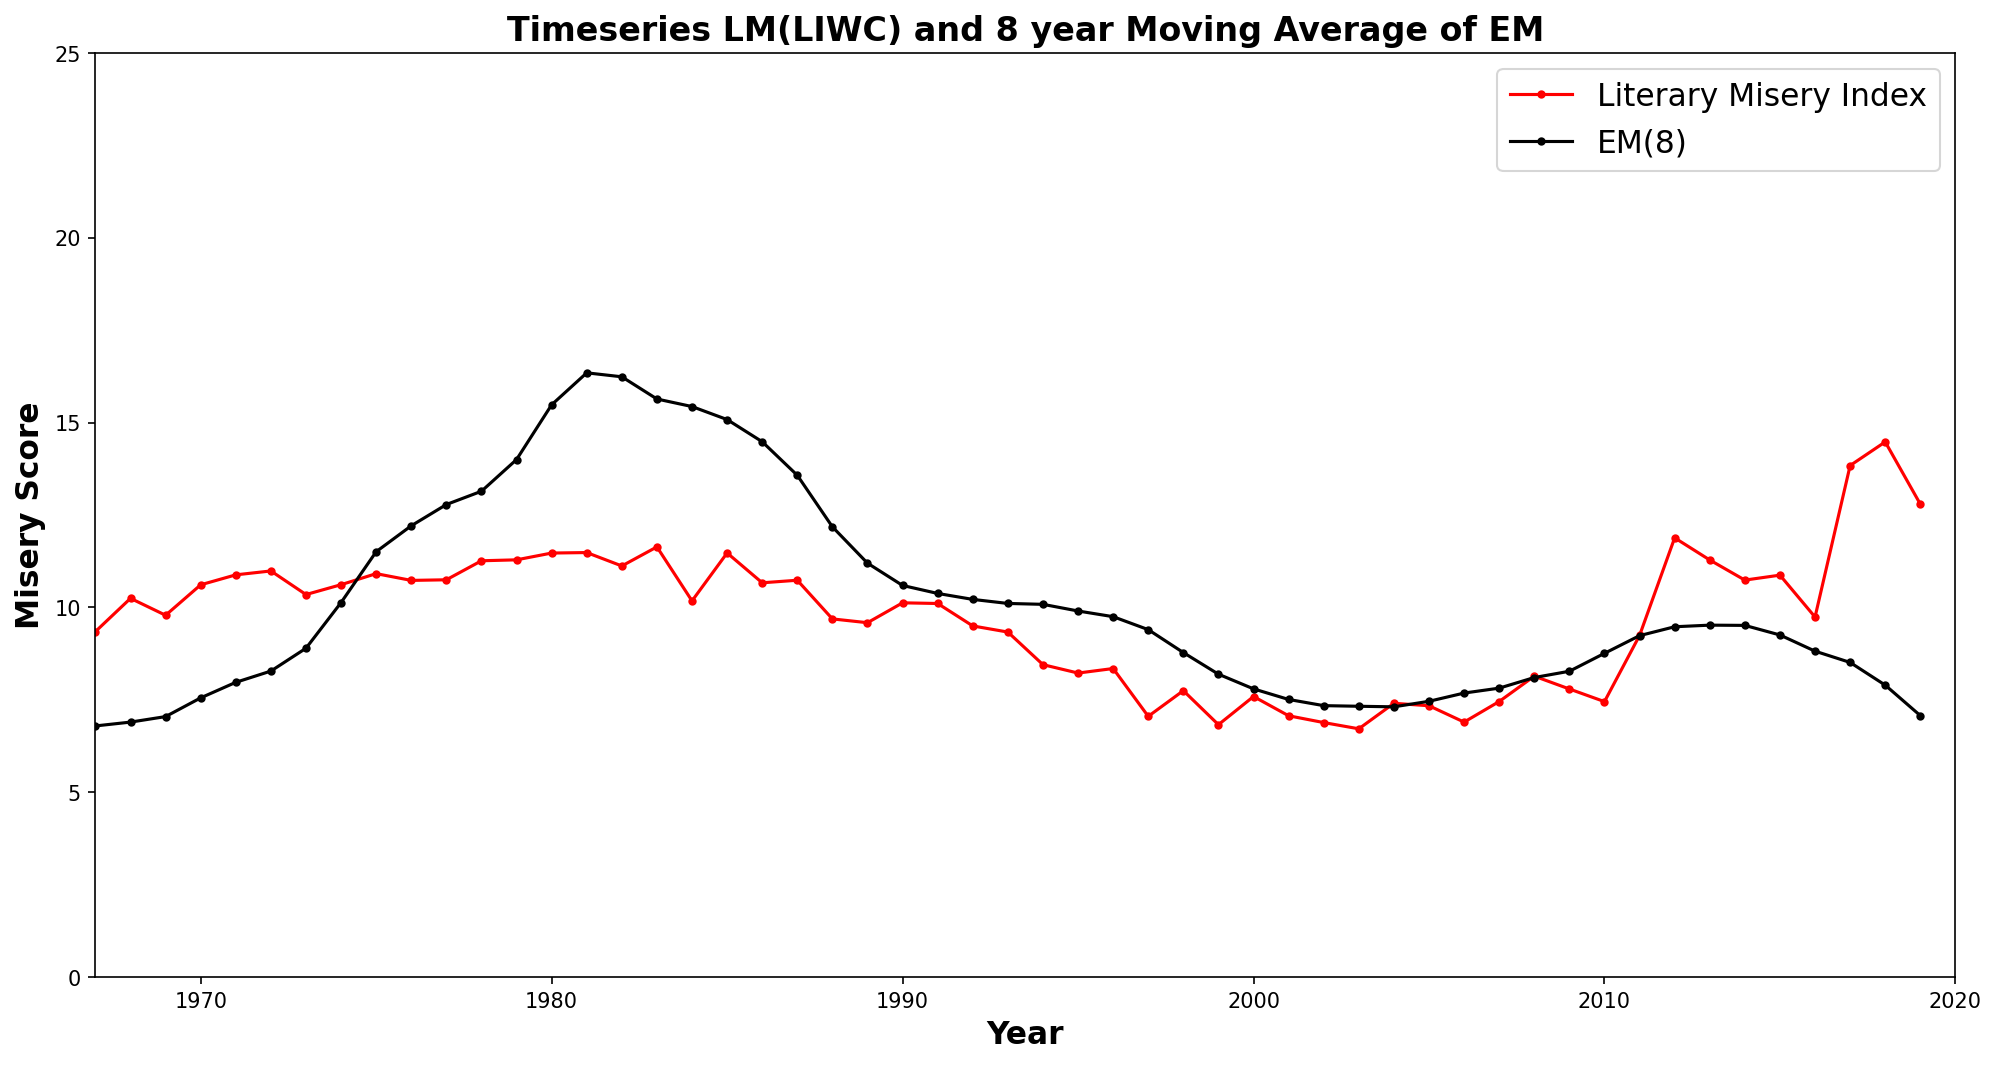

In [676]:
TimeSeries2Plot(series_r=LM_liwc_trans,label_r='Literary Misery Index',series_b=EM_8,label_b='EM(8)',xlab='Year',ylab='Misery Score',title='Timeseries LM(LIWC) and 8 year Moving Average of EM')

#### 2.2.3. Repeat analysis with sample 1960-2010

In [624]:
# filter out newer values
lm_liwc_short=LM_liwc_array[:51]
em_short=EM_US[:51]

#get correlations
short_liwc_corr=get_lag_correlations(LM_arr=lm_liwc_short, EM_series=em_short)

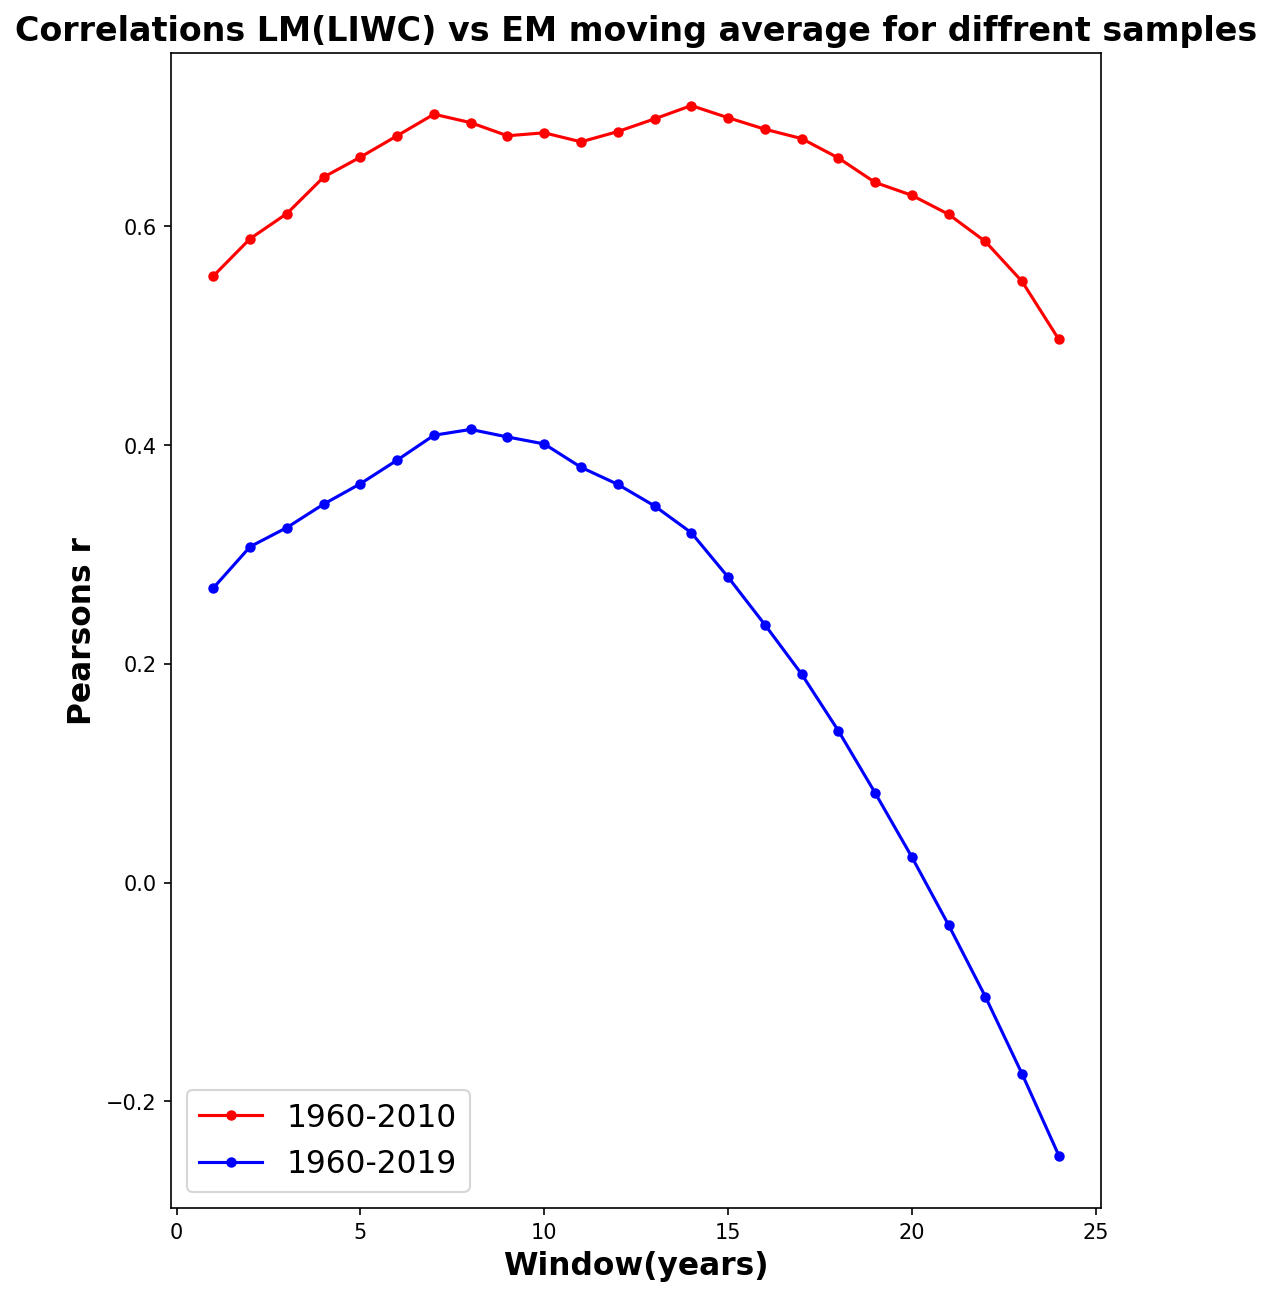

In [717]:
#define list for correlation with shorter period of time 
short_corr_liwc_ma=[elem['corr_ma'] for elem in short_liwc_corr]
Corr2Plot(lagvar=lags,series_r=short_corr_liwc_ma,label_r='1960-2010',series_b=corr_liwc_ma,label_b='1960-2019',xlab='Window(years)',ylab='Pearsons r',title='Correlations LM(LIWC) vs EM moving average for diffrent samples')

In [633]:
print(f'Max corr index lag: {short_corr_liwc_ma.index(max(short_corr_liwc_ma))}')
print(f'Max corr: {max(short_corr_liwc_ma)}')

Max corr index lag: 13
Max corr: 0.7104671536324896


In [886]:
#define get EM series based on index and form 
EM_ma_14_short=short_liwc_corr[13]['series_ma']
# get rid if the first observations that where cu because of the ma (same index) 
LM_liwc_14_short=lm_liwc_short[13:]
#get KI
c_liwc_ma_short=get_bootstraped_corrs(LM_list=LM_liwc_14_short,EM_series=EM_ma_14_short, sample_size=40)

KI for corr: [0.547313596360623, 0.8417805400234467]


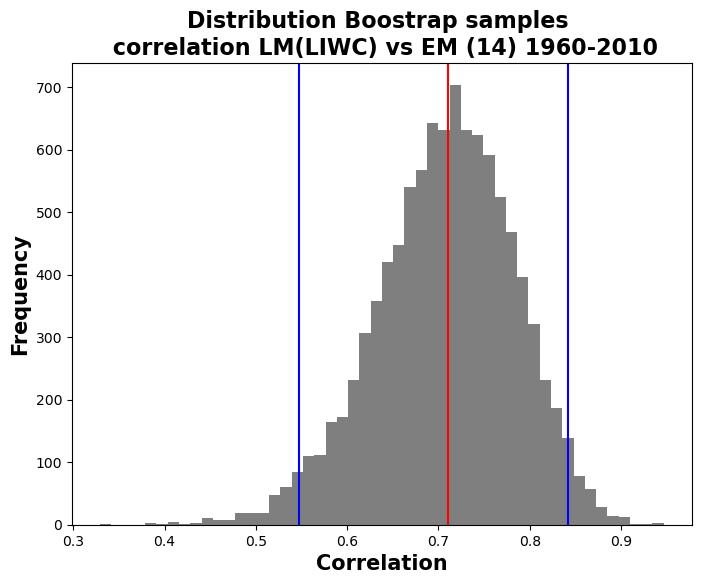

In [888]:
#plot histogram
plot_bootstrap(bootstraped_corrs=c_liwc_ma_short, realized_value=short_liwc_corr[13]['corr_ma'], title='Distribution Boostrap samples \n correlation LM(LIWC) vs EM (14) 1960-2010')

### 2.3. LIWC German

#### 2.3.1. Plot timereseries

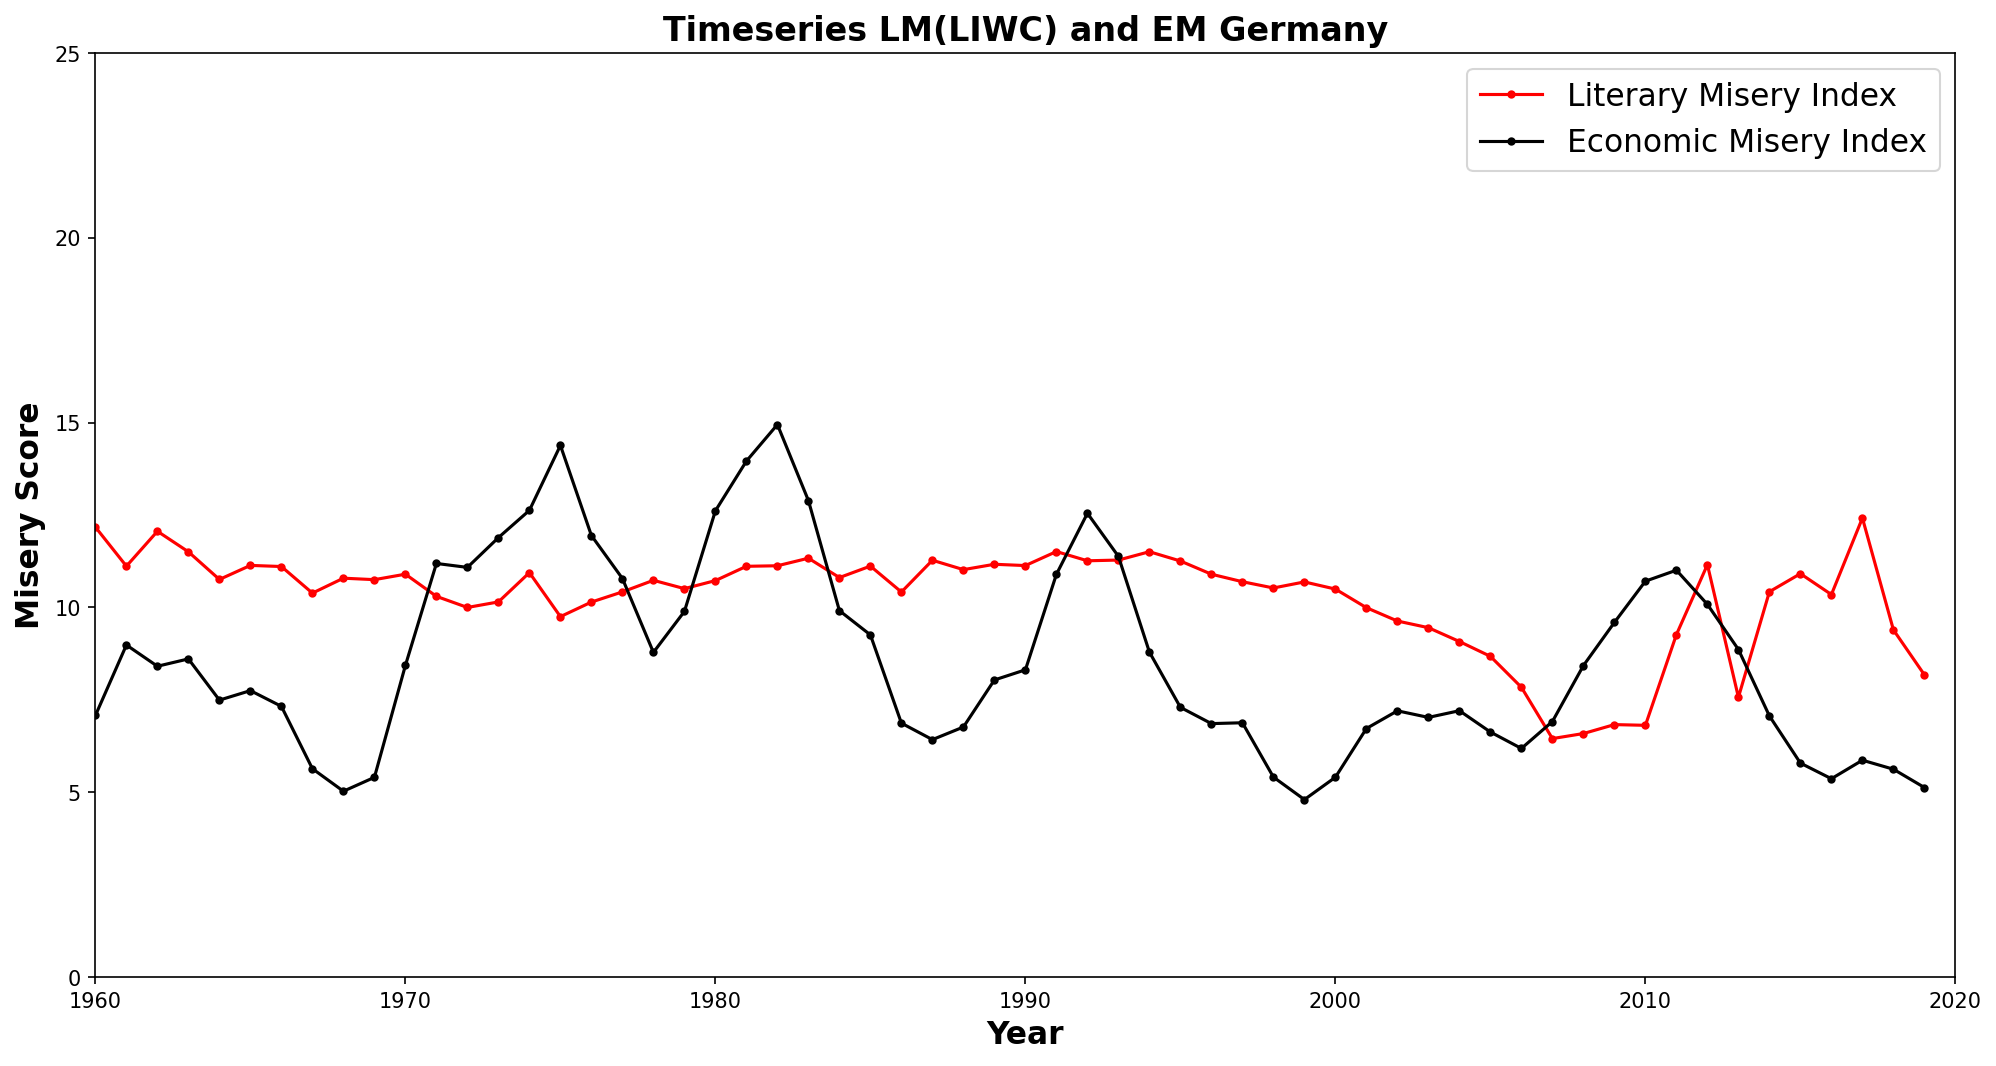

In [709]:
#filter out first 60 years 
LM_liwc_f_ger=LM_liwc_ger[60:]
EM_GER.index=range(1960,2020)
#scale LM to factor 10 for the plots and append to em series 
LM_liwc_trans_ger=pd.Series([LM*10 +10 for LM in LM_liwc_f_ger],index=range(1960,2020))
TimeSeries2Plot(series_r=LM_liwc_trans_ger,label_r='Literary Misery Index',series_b=EM_GER,label_b='Economic Misery Index',xlab='Year',ylab='Misery Score', title='Timeseries LM(LIWC) and EM Germany')

#### 2.2.2. Correlations

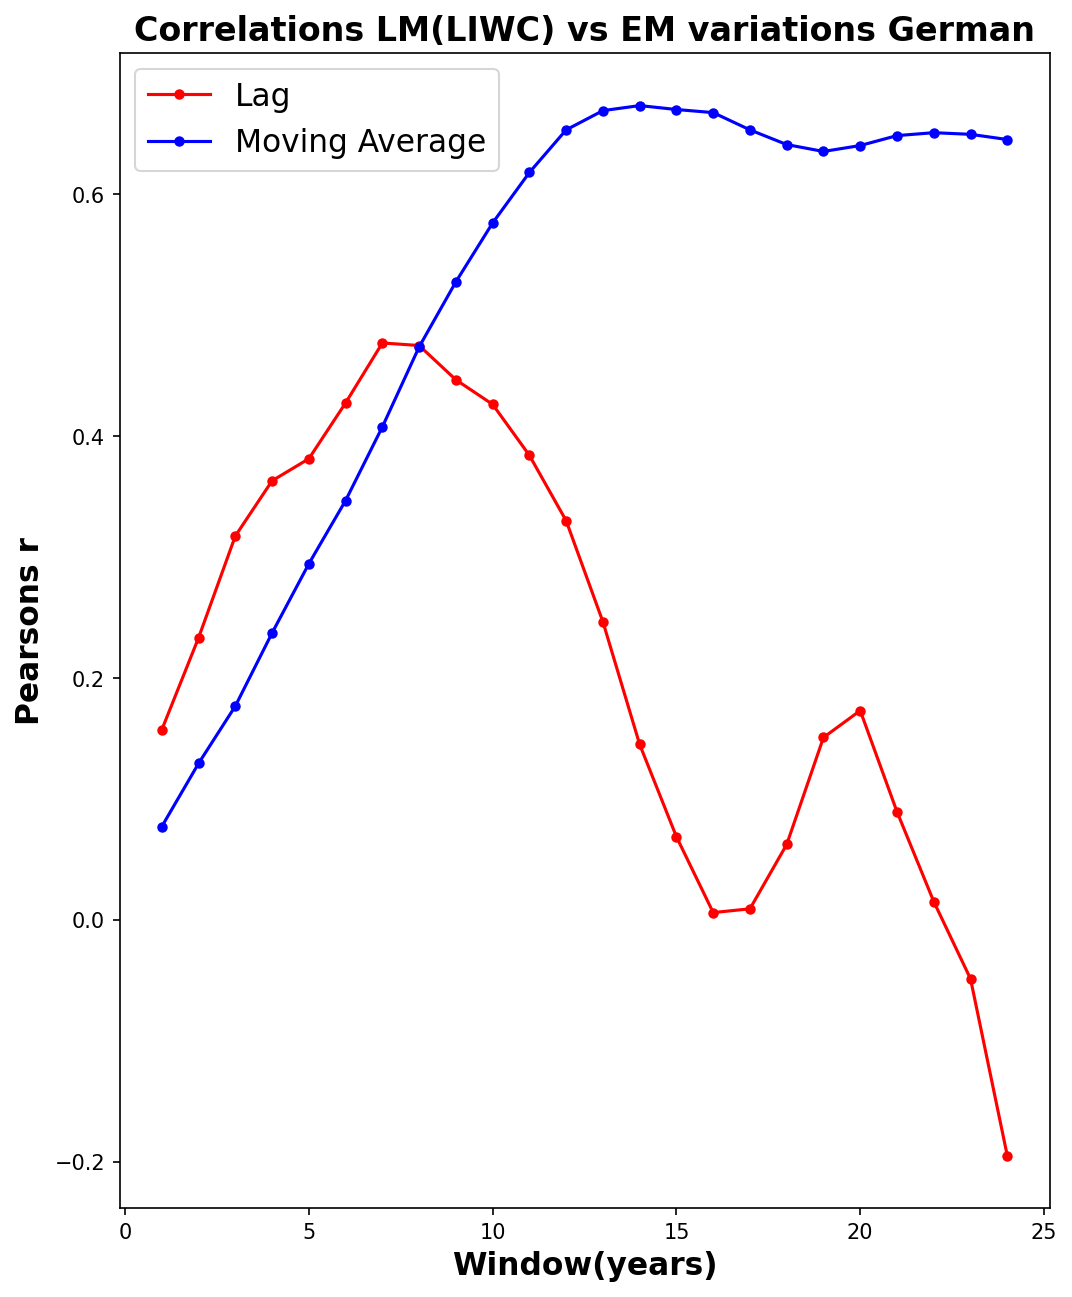

In [718]:
#turn LM to an array
LM_liwc_array_ger=np.array(LM_liwc_f_ger)

#get all series of lags and moving averages with their respective correlations
corr_liwc_res_ger=get_lag_correlations(LM_arr=LM_liwc_array_ger, EM_series=EM_GER)

## define sigle lists 
lags_liwc_ger=[elem['lag'] for elem in corr_liwc_res_ger]
corr_liwc_lag_ger=[elem['corr_l'] for elem in corr_liwc_res_ger]
corr_liwc_ma_ger=[elem['corr_ma'] for elem in corr_liwc_res_ger]

#plot correlations
Corr2Plot(lagvar=lags_liwc_ger,series_r=corr_liwc_lag_ger,label_r='Lag',series_b=corr_liwc_ma_ger,label_b='Moving Average',xlab='Window(years)',ylab='Pearsons r',title='Correlations LM(LIWC) vs EM variations German')

In [889]:
# get max value and index for moving average 
print(f'Max ma corr index: {corr_liwc_ma_ger.index(max(corr_liwc_ma_ger))}')
print(f'Max ma corr: {max(corr_liwc_ma_ger)}')

Max ma corr index: 13
Max ma corr: 0.6735325027756147


In [890]:
#define get EM series based on index and form 
EM_ma_14_ger=corr_liwc_res_ger[13]['series_ma']
# get rid if the first observations that where cu because of the ma (same index) 
LM_liwc_14_ger=LM_liwc_f_ger[13:]
#get KI
c_liwc_ma_ger=get_bootstraped_corrs(LM_list=LM_liwc_14_ger,EM_series=EM_ma_14_ger, sample_size=40)

KI for corr: [0.49632937787487447, 0.8088472715673112]


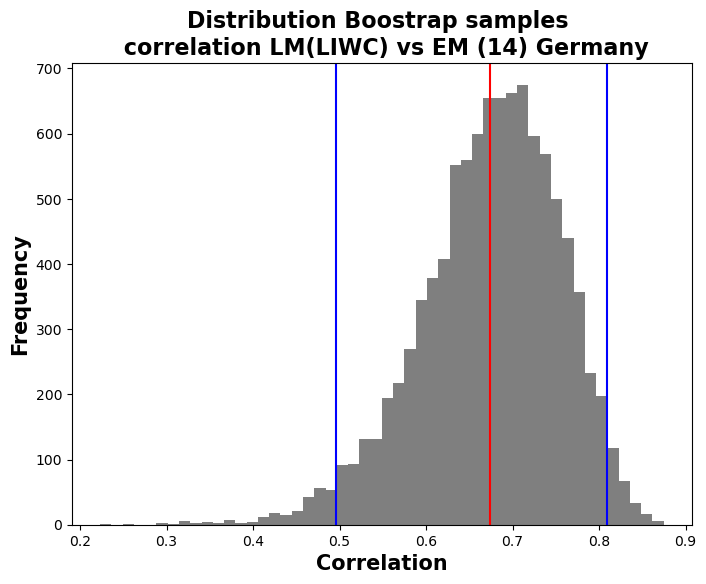

In [891]:
#plot histogram
plot_bootstrap(bootstraped_corrs=c_liwc_ma_ger, realized_value=corr_liwc_res_ger[13]['corr_ma'], title='Distribution Boostrap samples \n correlation LM(LIWC) vs EM (14) Germany')

In [714]:
# get max value and index for lagged series 
print(f'Max l corr index lag: {corr_liwc_lag_ger.index(max(corr_liwc_lag_ger))}')
print(f'Max l corr: {max(corr_liwc_lag_ger)}')

Max l corr index lag: 6
Max l corr: 0.4772224786587884


In [893]:
#define get EM series based on index and form 
EM_l_7_ger=corr_liwc_res_ger[6]['series_l']
# get rid if the first observations that where cu because of the lag (index + 1) 
LM_liwc_l7=LM_liwc_f_ger[7:]
#get KI
c_liwc_lag_ger=get_bootstraped_corrs(LM_list=LM_liwc_l7,EM_series=EM_l_7_ger, sample_size=40)

KI for corr: [0.2826705626805051, 0.6426048503743133]
